# Maske Detection with Neural Network

The main goal of this notebook is to create an algorithm that can detect whether person is wearing a mask or not. For this purpose we will use a neural network wich will be trained on a [dataset](https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset) containig almost 12,000 images.

**Libraries**

In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout

**Constants**

In [2]:
IMG_SIZE = 150
THRESH = 0.5
EPOCHS = 10
BATCH_SIZE = 32

## Load dataset

In [3]:
def create_dataset(path):
    dataset = {
        "img_path": [],
        "label": []
    }
    
    for directory in os.listdir(path):
        for img in os.listdir(os.path.join(path, directory)):
            dataset["img_path"].append(os.path.join(path, directory, img))
            if directory == "WithMask":
                dataset["label"].append("Mask")
            else:
                dataset["label"].append("No Mask")
    return dataset

In [4]:
valid = pd.DataFrame(create_dataset('data12k\Validation\\'))
train = pd.DataFrame(create_dataset('data12k\Train\\'))
test = pd.DataFrame(create_dataset('data12k\Test\\'))

In [5]:
train.head()

,img_path,label
0,data12k\Train\WithMask\10.png,Mask
1,data12k\Train\WithMask\100.png,Mask
2,data12k\Train\WithMask\1004.png,Mask
3,data12k\Train\WithMask\1005.png,Mask
4,data12k\Train\WithMask\1006.png,Mask


## Explore dataset

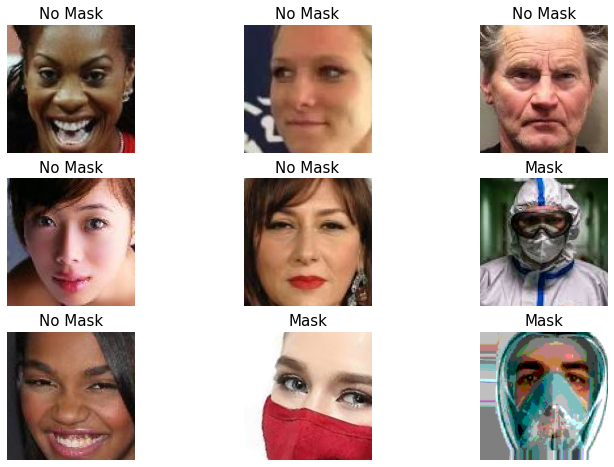

In [6]:
plt.figure(figsize = (12, 8))

for i in range(9):
    random = np.random.randint(1, len(train))
    plt.subplot(3, 3, i+1)
    plt.imshow(cv2.imread(train.loc[random,"img_path"])[:,:,::-1])
    plt.title(train.loc[random,"label"], size = 15)
    plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [7]:
train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)
valid = valid.sample(frac=1).reset_index(drop=True)

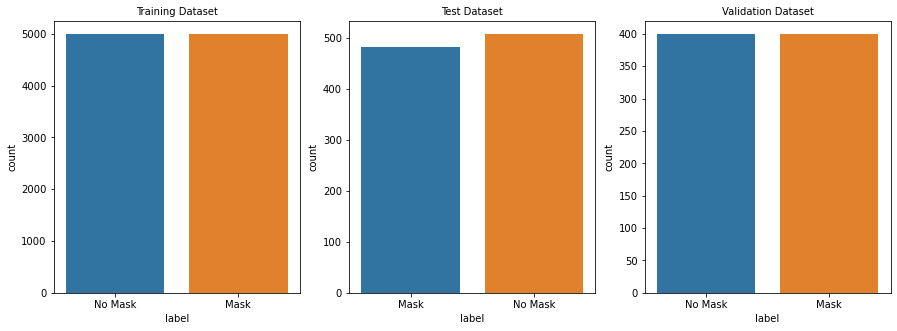

In [8]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x = train["label"])
plt.title("Training Dataset", size = 10)

plt.subplot(1, 3, 2)
sns.countplot(x = test["label"])
plt.title("Test Dataset", size = 10)

plt.subplot(1, 3, 3)
sns.countplot(x = valid["label"])
plt.title("Validation Dataset", size = 10)

plt.show()

## Preprocess

In [9]:
def preprocess_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  
    return img

def transform_dataset(dataset):
    X = []
    for img_path in dataset["img_path"]:
        X.append(preprocess_img(img_path))
    X = np.array(X)
    X = X/255
    di = {"Mask": 1.0, "No Mask": 0.0}
    y = dataset.replace({"label": di})["label"]
    y = np.float32(y)
    return X, y

In [10]:
X_train, y_train = transform_dataset(train)
X_test, y_test = transform_dataset(test)
X_valid, y_valid = transform_dataset(valid)

In [11]:
X_train.shape, y_train.shape

((10000, 150, 150), (10000,))

## Model

### Operations used in the neural network

**Input image**

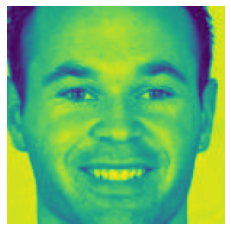

In [12]:
shapes = {}
tmp_img = preprocess_img('data12k\example.png')
tmp_img = tmp_img / 255
shapes["before conv"] = tmp_img.shape
plt.imshow(tmp_img)
plt.axis('off')
plt.show()

**Convolution**

In [13]:
tmp_img = tmp_img.reshape(1, X_train.shape[1], X_train.shape[2], 1)
shapes["After reshape"] = tmp_img.shape
y = tf.keras.layers.Conv2D(4, (3, 3), activation = "relu")(tmp_img)
shapes["After conv"] = y.shape

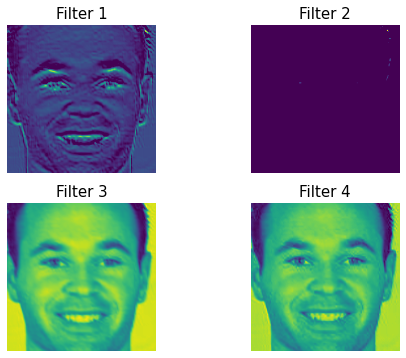

In [14]:
plt.figure(figsize = (8, 6))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(y[0][:][:][:][:,:,i])
    plt.title(f"Filter {i+1}", size = 15)
    plt.axis('off')
    
plt.show()

**Max Pooling 2D**

In [15]:
y = tf.keras.layers.MaxPool2D(pool_size=(3, 3))(y)
shapes["After MaxPool2D"] = y.shape

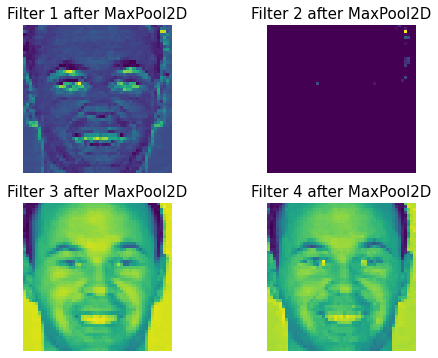

In [16]:
plt.figure(figsize = (8, 6))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(y[0][:][:][:][:,:,i])
    plt.title(f"Filter {i+1} after MaxPool2D", size = 15)
    plt.axis('off')
    
plt.show()

**Shape changes**

In [17]:
shapes

{'before conv': (150, 150),
 'After reshape': (1, 150, 150, 1),
 'After conv': TensorShape([1, 148, 148, 4]),
 'After MaxPool2D': TensorShape([1, 49, 49, 4])}

### Building a model

#### Reshaping data

In [18]:
X_valid = X_valid.reshape(len(X_valid), X_valid.shape[1], X_valid.shape[2], 1)
X_train = X_train.reshape(len(X_train), X_train.shape[1], X_train.shape[2], 1)
X_valid.shape

(800, 150, 150, 1)

#### Model architecture

Now we can create a neural netork. We will use the architecture which was advised in this [article](https://www.sciencedirect.com/science/article/pii/S2666285X21000157).

In [19]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid"))

In [20]:
model.build((1, 150, 150, 1))

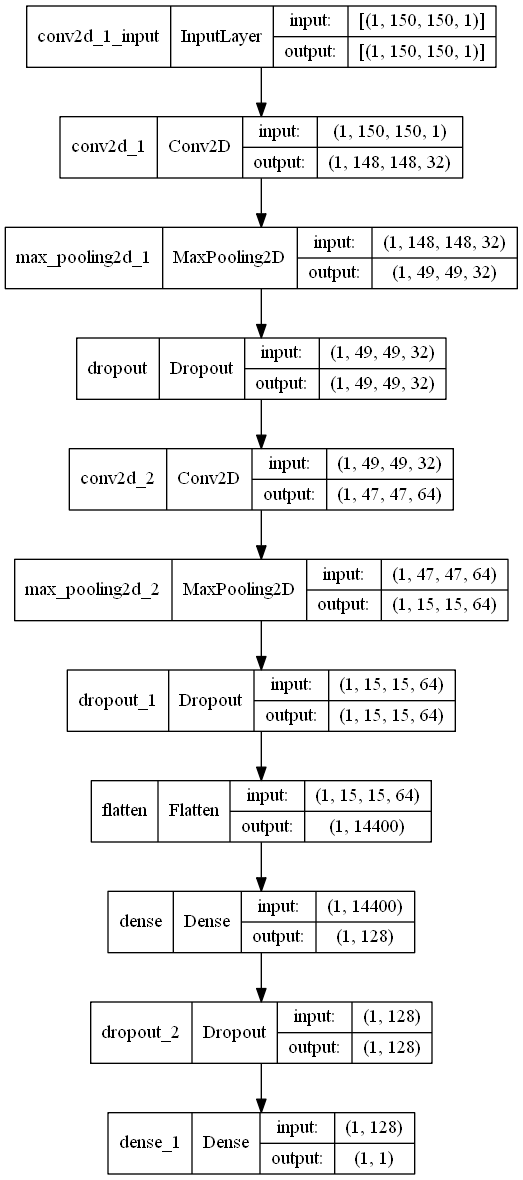

In [21]:
plot_model(model, show_shapes=True, show_layer_names=True)

#### Training

In [22]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=2, restore_best_weights=True)

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [24]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_valid, y_valid), 
                    epochs = EPOCHS, 
                    batch_size = BATCH_SIZE,
                    callbacks=[es])

Epoch 1/10
313/313 [==============================] - 52s 165ms/step - loss: 0.2748 - accuracy: 0.8716 - val_loss: 0.1083 - val_accuracy: 0.9538
Epoch 2/10
313/313 [==============================] - 52s 165ms/step - loss: 0.0945 - accuracy: 0.9668 - val_loss: 0.0808 - val_accuracy: 0.9725
Epoch 3/10
313/313 [==============================] - 51s 163ms/step - loss: 0.0730 - accuracy: 0.9749 - val_loss: 0.0588 - val_accuracy: 0.9775
Epoch 4/10
313/313 [==============================] - 51s 163ms/step - loss: 0.0521 - accuracy: 0.9820 - val_loss: 0.0703 - val_accuracy: 0.9737
Epoch 5/10
313/313 [==============================] - 51s 163ms/step - loss: 0.0446 - accuracy: 0.9839 - val_loss: 0.0974 - val_accuracy: 0.9563


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 49, 49, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 64)        0

#### Accuracy and loss

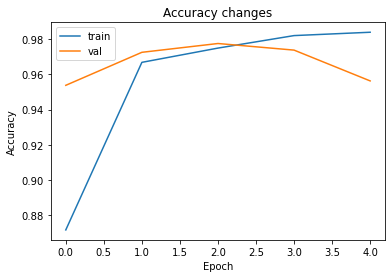

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy changes')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

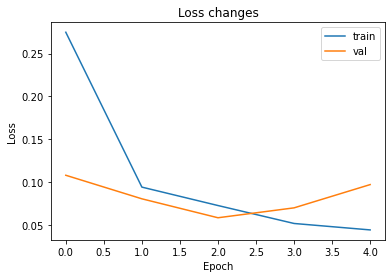

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss changes')
plt.legend(['train', 'val'])
plt.show()

## Predictions

### Make predictions

In [28]:
preds = model.predict(X_test)
preds = preds.round(2)

In [29]:
def make_decision(value):
    if value > THRESH:
        return "Mask"
    else:
        return "No Mask"

In [30]:
results = pd.concat([pd.Series(test["label"]), pd.Series(preds[:,0], name="confidence")], axis=1)
results["decision"] = results["confidence"].apply (lambda row: make_decision(row))
results["diff"] = results["label"] == results["decision"]
results.head()

,label,confidence,decision,diff
0,Mask,1.00,Mask,True
1,No Mask,0.00,No Mask,True
2,Mask,0.95,Mask,True
3,Mask,1.00,Mask,True
4,No Mask,0.00,No Mask,True


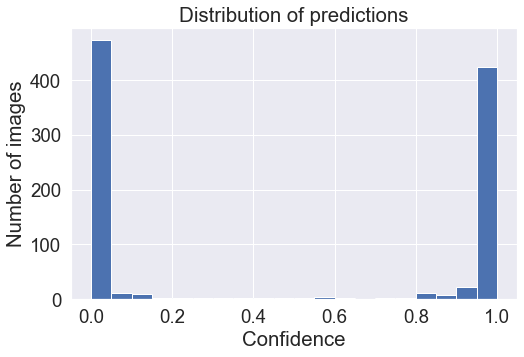

In [50]:
plt.figure(figsize=(8,5))
plt.hist(results["confidence"], bins=20)
plt.title("Distribution of predictions")
plt.xlabel("Confidence")
plt.ylabel("Number of images")
plt.show()

In [31]:
print(f"Accuracy: {100 * round(results['diff'].mean(), 4)}%")

Accuracy: 97.78%


### Confusion Matrix

In [32]:
true_pos = len(results[(results["label"] == "Mask") & (results["decision"] == "Mask")])
true_neg = len(results[(results["label"] == "No Mask") & (results["decision"] == "No Mask")])
false_pos = len(results[(results["label"] == "No Mask") & (results["decision"] == "Mask")])
false_neg = len(results[(results["label"] == "Mask") & (results["decision"] == "No Mask")])
arr = [[true_pos, false_pos], [false_neg, true_neg]]

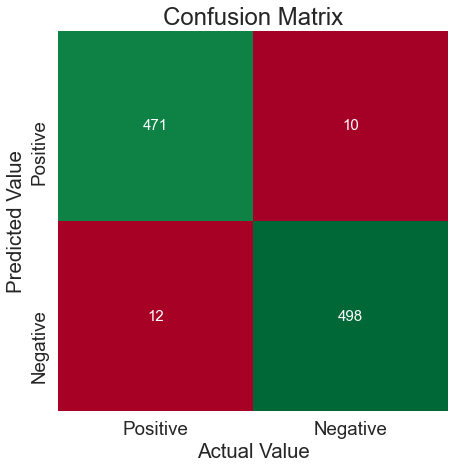

In [33]:
df_cm = pd.DataFrame(arr, range(2), range(2))
plt.figure(figsize=(7,7))
sns.set(font_scale=1.7)
sns.heatmap(df_cm,
            cmap = "RdYlGn",
            annot=True, 
            cbar=False, 
            fmt='', 
            xticklabels = ["Positive", "Negative"],
            yticklabels = ["Positive", "Negative"],
            annot_kws={"size": 15})
plt.title("Confusion Matrix", fontsize=24)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.show()

In [34]:
precision = true_pos/(true_pos + false_pos)
recall = true_pos/(true_pos + false_neg)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {100 * round(precision, 4)}%")
print(f"Racall: {100 * round(recall, 4)}%")
print(f"F1 score: {100 * round(f1_score, 4)}%")

Precision: 97.92%
Racall: 97.52%
F1 score: 97.72%


### Check Results

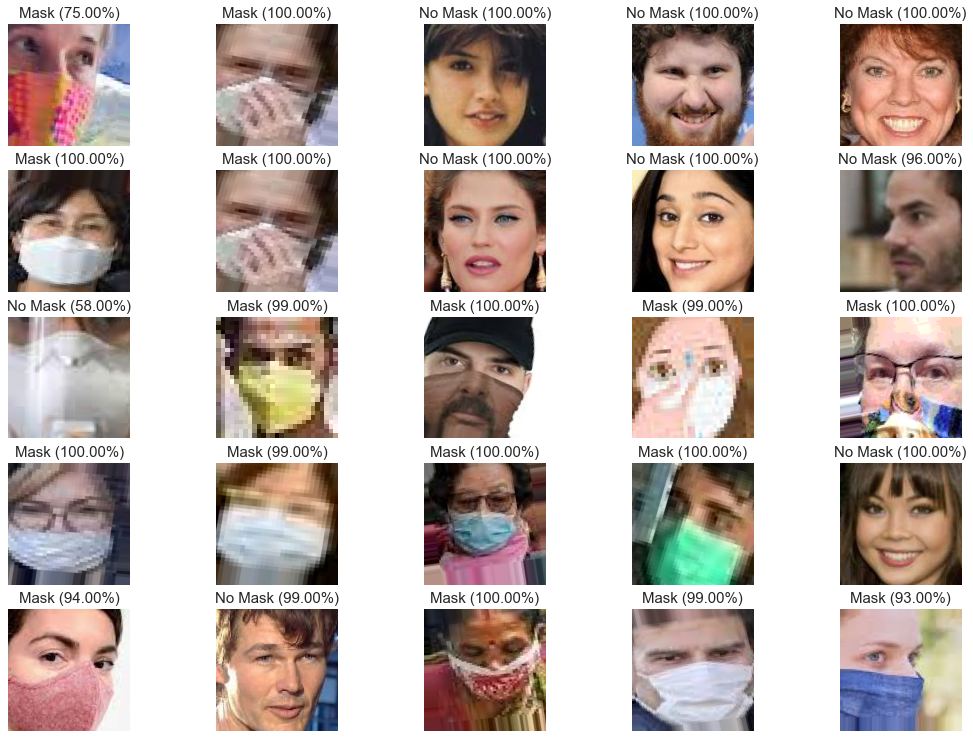

In [35]:
plt.figure(figsize = (18, 13))

for i in range(25):
    random = np.random.randint(1, len(test))
    plt.subplot(5, 5, i+1)
    plt.imshow(cv2.imread(test.loc[random,"img_path"])[:,:,::-1])
    if results.loc[random, "decision"] == "Mask":
        plt.title("{} ({:.2f}%)".format(results.loc[random, "decision"], 100 * results.loc[random, "confidence"]), size=15)
    else:
        plt.title("{} ({:.2f}%)".format(results.loc[random, "decision"], 100 * (1 - results.loc[random, "confidence"])), size=15)
    plt.axis('off')

plt.show()

### Mistakes

In [36]:
mistakes = results[results["label"] != results["decision"]]
mistakes

,label,confidence,decision,diff
49,No Mask,0.94,Mask,False
73,No Mask,0.87,Mask,False
153,No Mask,0.95,Mask,False
200,No Mask,0.58,Mask,False
231,Mask,0.43,No Mask,False
270,Mask,0.27,No Mask,False
312,Mask,0.21,No Mask,False
314,No Mask,0.64,Mask,False
356,Mask,0.15,No Mask,False
358,Mask,0.26,No Mask,False


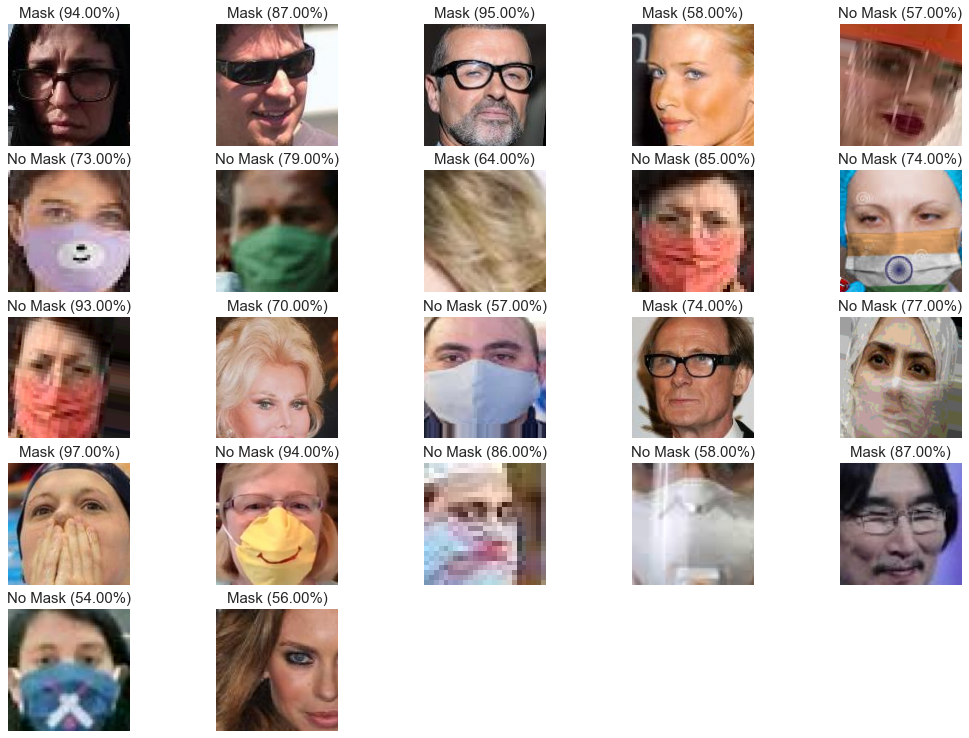

In [37]:
plt.figure(figsize = (18, 13))

for i in range(25):
    index = mistakes.index[i]
    plt.subplot(5, 5, i+1)
    plt.imshow(cv2.imread(test.loc[index,"img_path"])[:,:,::-1])
    if results.loc[index, "decision"] == "Mask":
        plt.title("{} ({:.2f}%)".format(results.loc[index, "decision"], 100 * results.loc[index, "confidence"]), size=15)
    else:
        plt.title("{} ({:.2f}%)".format(results.loc[index, "decision"], 100 * (1 - results.loc[index, "confidence"])), size=15)
    plt.axis('off')
    if i == len(mistakes.index) - 1:
        break

plt.show()